In [1]:
import numpy as np
from scipy import linalg
from tensorly import *
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
TENSOR_ORDER = 3
CORE_TENSOR_SHAPE = (2, 2, 2)
tensor = np.random.randint(0, 5, size=CORE_TENSOR_SHAPE)

### Important interpretation

---

Each entry of a numpy tensor is of the form $X_{IJK}$, but while printing the tensor, it does not print the tensor sheet ($k$) wise. Instead it prints in the indexing order. So the sheets you will see will be first row level sheets $i$ and then $j$ level and then $k$ level sheets.

In [3]:
X  = np.arange(24).reshape(3,4,2) # row, col, depth (your choice your interpretation)
print(X)

[[[ 0  1]
  [ 2  3]
  [ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]
  [12 13]
  [14 15]]

 [[16 17]
  [18 19]
  [20 21]
  [22 23]]]


In [4]:
print(X[2][2][1]) # k, i, j indexing according to the picure here

21


In [5]:
print(X[...,1])

[[ 1  3  5  7]
 [ 9 11 13 15]
 [17 19 21 23]]


In [6]:
unfolded = unfold(X, 0) # mode 1 matricization of the tensor
print(unfolded)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]]


In [7]:
print(X.reshape(-1, 3, order='F'))

[[ 0 20 11]
 [ 8  6 19]
 [16 14  5]
 [ 2 22 13]
 [10  1 21]
 [18  9  7]
 [ 4 17 15]
 [12  3 23]]


In [8]:
class CP:
    def __init__(self, tensor, rank, max_iter=10000, eps=0.01):
        """
        PARAFAC decompositon, it initializes the maximum amount of iterations that 
        are done along with the tolerance value for the convergence
        it also takes the size of the core tensor `rank`
        """
        self.tensor = tensor
        self.rank = rank
        self.max_iter = max_iter
        self.eps = eps
        self.prod_norms = []
        self.prod_kr_norms = []
        self.factor_update_norms = []
        self.core_norms = []
        self.errors = []
        self.factors = []
        self.core = np.zeros(CORE_TENSOR_SHAPE)

        np.fill_diagonal(self.core, 1)
         
    def fit(self):
        self._init_factors()
        for i in range(self.max_iter):
            for mode in reversed(range(TENSOR_ORDER)):
                self._update_factors(mode)
            if self._is_converged():
                break
        print("Converged in {} iterations".format(i))
        print("Final error = ", self.errors[-1])
    
    def _size_check(self, mode):
        print("------------------------- Mode {} -------------------------".format(mode))
        print ("Size of the tensor = ", self.tensor.shape)
        print ("Size of the core tensor = ", self.core.shape)
        print ("Size of factor mode = ", self.factors[mode].shape)
        print ("Size of the unfolded tensor = ", unfold(self.tensor, mode).shape)
        print ("Size of the Khatri-Rao product = ", linalg.khatri_rao(self.factors[0], self.factors[1]).shape)
    
    def _init_factors(self):
        """
        initialize the factors using the `rank` many left singular 
        vectors of the corresponding mode-n matricization of the input tensor
        """
        matricized = [unfold(self.tensor, mode) for mode in range(TENSOR_ORDER)]
        self.factors = [linalg.svd(matrix, full_matrices=False)[0][:, :self.rank] for matrix in matricized]
        print("Initialized factors")
        pass
    
    def _update_factors(self, mode):
        """
        Update the factors per iteration for the `mode`'th Factor
        """
        # compute hadamard product of the gram matrices of other factors
        prod = np.ones((self.rank, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod = np.multiply(prod, self.factors[pos].T @ self.factors[pos])
        self.prod_norms.append(np.linalg.norm(prod))
        # compute the Khatri-Rao product of the other factors
        prod_kr = np.ones((1, self.rank))
        for pos in reversed(range(TENSOR_ORDER)):
            if(mode != pos):
                prod_kr = linalg.khatri_rao(prod_kr, self.factors[pos])
        
        self.prod_kr_norms.append(np.linalg.norm(prod_kr))
        
        W = unfold(self.tensor, mode) @ prod_kr
        
        # now solve the least squares problem
        self.factors[mode] = W @ np.linalg.pinv(prod)
        # now normalize the factor and update the core tensor
        col_norms = np.linalg.norm(self.factors[mode], axis=0)
        self.factors[mode] = self.factors[mode] / col_norms # normalize the self.factors[mode]
        self.factor_update_norms.append(np.linalg.norm(self.factors[mode]))
        
        norm_identity = np.zeros(CORE_TENSOR_SHAPE)
        np.fill_diagonal(norm_identity,1)
        self.core = norm_identity
        self.core_norms.append(np.linalg.norm(self.core))
        # self._size_check(mode)
        pass
    
    def _is_converged(self):
        """
        check if the algorithm has converged
        by computing the Frobenius norm of the difference between the current tensor
        and the tensor obtained by multiplying the factors
        """
        # intitialize the core identitiy tensor
        

        # print(core)
        estim = tenalg.multi_mode_dot(self.core, self.factors)
        error = np.linalg.norm(self.tensor - estim)
        print("Error = ", error)
        self.errors.append(error)
        return error < self.eps
    
    def plot_errors(self):
        plt.plot(self.errors)
        # plt.plot(self.prod_norms)
        # plt.plot(self.prod_kr_norms)
        # plt.plot(self.factor_update_norms)
        # plt.plot(self.core_norms)
        plt.legend(["Errors"])
        plt.xlabel("Iterations")
        plt.ylabel("Frobenius norm")
        plt.show()
        
        
        

In [9]:
for pos in reversed(range(TENSOR_ORDER)):
    print(pos)

2
1
0


In [10]:
decomp = CP(tensor, rank=2)
factors = decomposition.parafac(tensor, rank=2)

In [11]:
decomp.fit()

Initialized factors
Error =  5.025987608862284
Error =  5.472405592342313
Error =  4.758809484413181
Error =  4.691123597974632
Error =  4.658074433743839
Error =  5.925371450222216
Error =  5.341025841539828
Error =  5.243406798800629
Error =  4.508682597480677
Error =  5.052430879315438
Error =  5.802388423761079
Error =  5.718880778364407
Error =  5.428414918939598
Error =  5.0553842147776615
Error =  6.034102495008034
Error =  5.231231921219889
Error =  5.954915739861603
Error =  5.934275163973733
Error =  6.006365719639187
Error =  5.0594143633071065
Error =  5.609939284999184
Error =  5.501861612566591
Error =  5.372824347371497
Error =  5.3250671798229625
Error =  4.533574460143247
Error =  4.721787755510091
Error =  4.885445001143576
Error =  5.411104317670975
Error =  5.157136280752895
Error =  4.4557050181905105
Error =  4.90035749612372
Error =  5.690870747506832
Error =  5.263766503434032
Error =  4.490223213040045
Error =  6.108056313603087
Error =  5.386135818258226
Error

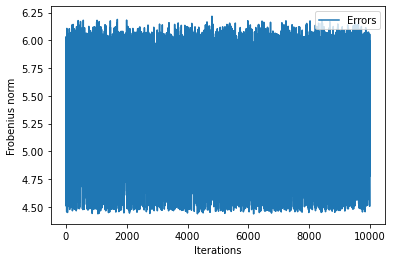

In [12]:
decomp.plot_errors()

In [13]:
decomp.core

array([[[1., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 1.]]])

In [14]:
decomp.factors

[array([[ 0.05641851, -0.94481743],
        [ 0.99840721,  0.32759736]]),
 array([[-0.9987625 , -0.92297993],
        [ 0.04973395, -0.3848481 ]]),
 array([[-0.75299324,  0.4774546 ],
        [-0.65802825,  0.87865642]])]

In [15]:
factors[0]

array([1., 1.])

In [16]:
factors[1]

[array([[ 4.95654737, -0.76312343],
        [ 3.3881095 , -1.21857729]]),
 array([[ 1.0503403 , -1.66876899],
        [ 0.09868581,  0.1904    ]]),
 array([[ 0.37675768,  0.81495148],
        [ 1.34415478, -2.35295903]])]

In [18]:
identity = np.zeros(CORE_TENSOR_SHAPE)
np.fill_diagonal(identity, factors[0])
estim_tensorly = tenalg.multi_mode_dot(identity, factors[1])
print(np.linalg.norm(tensor - estim_tensorly))

0.09139436939898352
